### Создаем выборку

$x_k = 0.5\sin kh + \text{norm}(0,1)$

In [96]:
import numpy as np

h = 0.1
k = 500
k_list = [i for i in range(k+1)]

nd = np.random.standard_normal(k+1)
x_orig = np.array([0.5*np.sin(i*h) for i in range(k+1)])

x = x_orig + nd
print(x[:10])

[ 1.47024618  2.08999541 -0.23211563 -1.13624685  0.92963236  0.11184107
  1.08012315 -0.28105061  1.39374968  0.50095589]


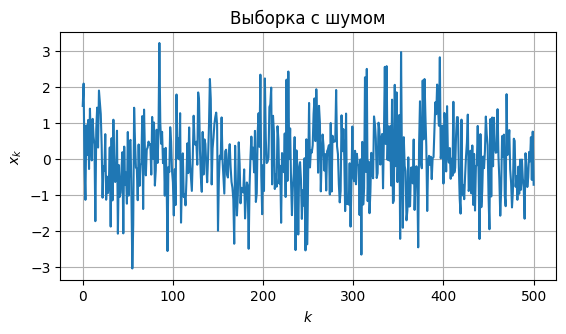

In [97]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(k_list, x)
ax.grid()
plt.xlabel("$k$")
plt.ylabel("$x_k$")
plt.title("Выборка с шумом")
ratio = 0.5
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# plt.axis('equal')
plt.show()

### Вычисляем экспоненциальное скользящее среднее

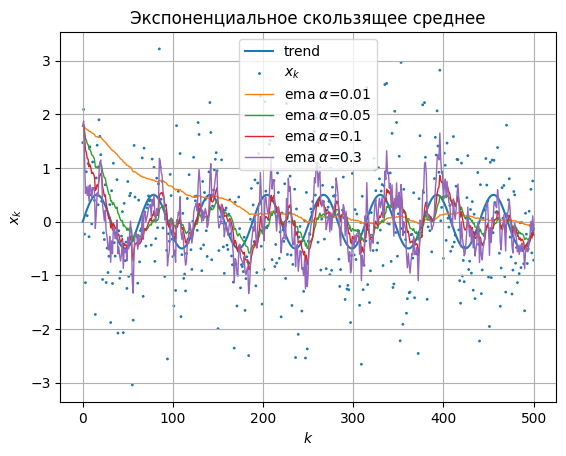

In [98]:
def ema(data, a):
    y = []
    y.append((data[0] + data[1])/2)
    for i in range(1, k+1):
        y.append(a*data[i] + (1-a)*y[i-1])
    return y


ema_list = []
for a in [0.01, 0.05, 0.1, 0.3]:
    ema_list.append(np.array(ema(x, a)))

plt.plot(k_list, x_orig, label='trend')
plt.scatter(k_list, x, label='$x_k$', s=[1]*len(k_list))
for i, a in enumerate([0.01, 0.05, 0.1, 0.3]):
    plt.plot(k_list, ema_list[i], label=f'ema $\\alpha$={a}', linewidth=1)
plt.grid()
plt.legend()
plt.xlabel("$k$")
plt.ylabel("$x_k$")
plt.title("Экспоненциальное скользящее среднее")
plt.show()

### Делаем преобразование Фурье

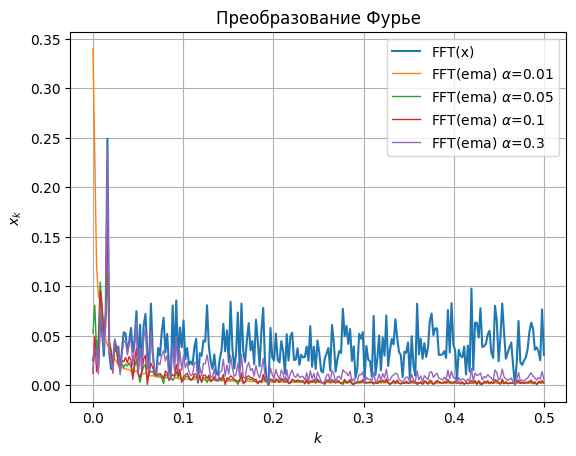

In [99]:
def FFT(x):
    fft = np.fft.fft(x)
    # a: np.complex128 = [1, 2]
    # print(a)
    abs_fft = []
    for i in range(len(fft)):
        # abs_fft.append(fft[i].real)
        abs_fft.append(abs(fft[i]))
    return np.array(abs_fft)

fft_x = FFT(x)
fft_list = []
for em in ema_list:
    fft_list.append(FFT(em))

# plt.yscale("log")
ordi = np.linspace(0, 0.5, len(k_list)//2)
plt.plot(ordi, fft_x[:len(fft_x)//2]/k, label='FFT(x)')
for i, a in enumerate([0.01, 0.05, 0.1, 0.3]):
    plt.plot(ordi, fft_list[i][:len(fft_list[i])//2]/k, label=f'FFT(ema) $\\alpha$={a}', linewidth=1)
# plt.plot(k_list[:len(k_list)//2], fft_list[0][:len(k_list)//2], label=f'FFT(ema) $\\alpha$={0.01}', linewidth=1)
plt.grid()
plt.legend()
plt.xlabel("$k$")
plt.ylabel("$x_k$")
plt.title("Преобразование Фурье")
plt.show()

### Оставляем только шум

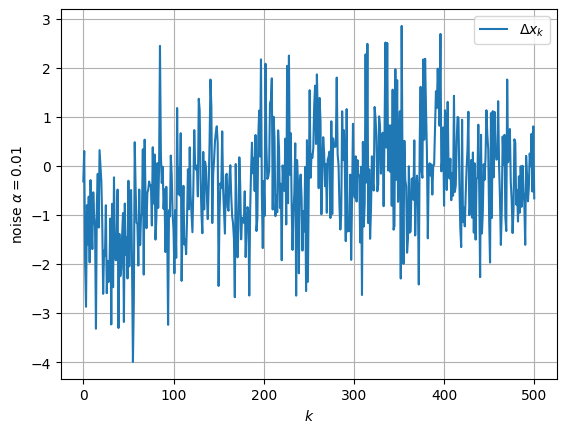

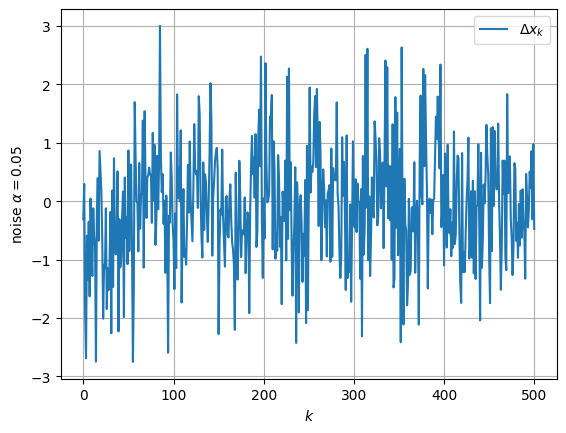

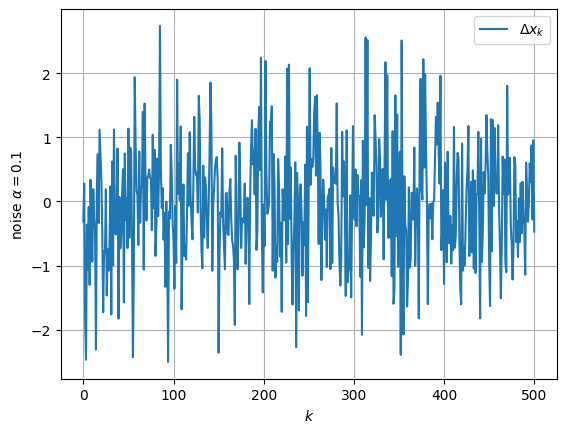

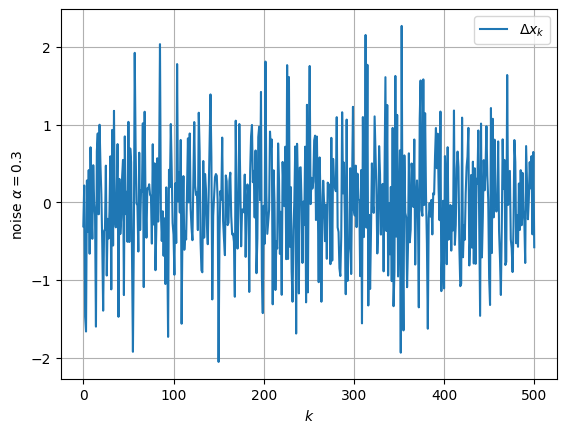

In [100]:
noise_ema = np.empty((len(ema_list), len(ema_list[0])))
for i in range(len(ema_list)):
    noise_ema[i] = x - ema_list[i]

for i, a in enumerate([0.01, 0.05, 0.1, 0.3]):
    plt.plot(k_list, noise_ema[i], label='$\\Delta x_k$')
    plt.grid()
    plt.legend()
    plt.xlabel("$k$")
    plt.ylabel("$\\text{noise}\ \\alpha = $"+f"{a}")
    plt.title("")
    plt.show()

### Поворотные точки и Кендалл

In [101]:
def turning_points(data):
    p = 0
    for i in range(len(data) - 2):
        if data[i] < data[i+1] and data[i+1] > data[i+2]:
            p += 1
        if data[i] > data[i+1] and data[i+1] < data[i+2]:
            p += 1
    return p

def kendall_coefficient(data, n):
    p = 0
    for i in range(len(data) - 1):
        for j in range(i+1, len(data)):
            if data[j] > data[i]:
                p += 1
    return 4*p/(n*(n-1)) - 1

### Проверяем тренды

In [102]:
E_t = 0
D_t = 2*(2*(k+1)+5)/(9*(k+1)*k)
s_t = np.sqrt(D_t)

print("E_t = ", E_t)
print("D_t = ", D_t)
print("s_t = ", s_t)

for i, a in enumerate([0.01, 0.05, 0.1, 0.3]):
    print("Среднее = ", noise_ema[i].mean())
    t = kendall_coefficient(noise_ema[i], k+1)
    print(f"t_{i} = {t}")
    if t > E_t + s_t:
        print("Возрастяющий тренд")
    elif t < E_t - s_t:
        print("Убывающий тренд")
    else:
        print("Ряд случаен")

E_t =  0
D_t =  0.0008933244621867376
s_t =  0.02988853395847206
Среднее =  -0.36417211529333515
t_0 = 0.21333333333333337
Возрастяющий тренд
Среднее =  -0.07741439209143591
t_1 = 0.05531337325349295
Возрастяющий тренд
Среднее =  -0.03705973600030959
t_2 = 0.027465069860279412
Ряд случаен
Среднее =  -0.009557966334912724
t_3 = 0.005588822355289347
Ряд случаен
